# LSTM Strategy 

### References
https://www.tensorflow.org/tutorials/structured_data/time_series

https://www.datacamp.com/tutorial/lstm-python-stock-market

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424




In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

import yfinance as yf
from backtesting import Strategy, Backtest 
from backtesting.lib import crossover

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [204]:
#get stock data 

#Apple Inc. 
#aapl = yf.Ticker("AAPL") 
#data = aapl.history(start="2000-01-01", end="2020-01-01")

#Google
goog = yf.Ticker("GOOG") #Apple Inc. 
data = goog.history(start="2000-01-01", end="2020-01-01")

#S&P 500 
#gspc = yf.Ticker("^GSPC")  
#data = gspc.history(start="2000-01-01", end="2020-01-01")

In [205]:
data.keys()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [206]:
data.index

DatetimeIndex(['2004-08-19 00:00:00-04:00', '2004-08-20 00:00:00-04:00',
               '2004-08-23 00:00:00-04:00', '2004-08-24 00:00:00-04:00',
               '2004-08-25 00:00:00-04:00', '2004-08-26 00:00:00-04:00',
               '2004-08-27 00:00:00-04:00', '2004-08-30 00:00:00-04:00',
               '2004-08-31 00:00:00-04:00', '2004-09-01 00:00:00-04:00',
               ...
               '2019-12-17 00:00:00-05:00', '2019-12-18 00:00:00-05:00',
               '2019-12-19 00:00:00-05:00', '2019-12-20 00:00:00-05:00',
               '2019-12-23 00:00:00-05:00', '2019-12-24 00:00:00-05:00',
               '2019-12-26 00:00:00-05:00', '2019-12-27 00:00:00-05:00',
               '2019-12-30 00:00:00-05:00', '2019-12-31 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=3869, freq=None)

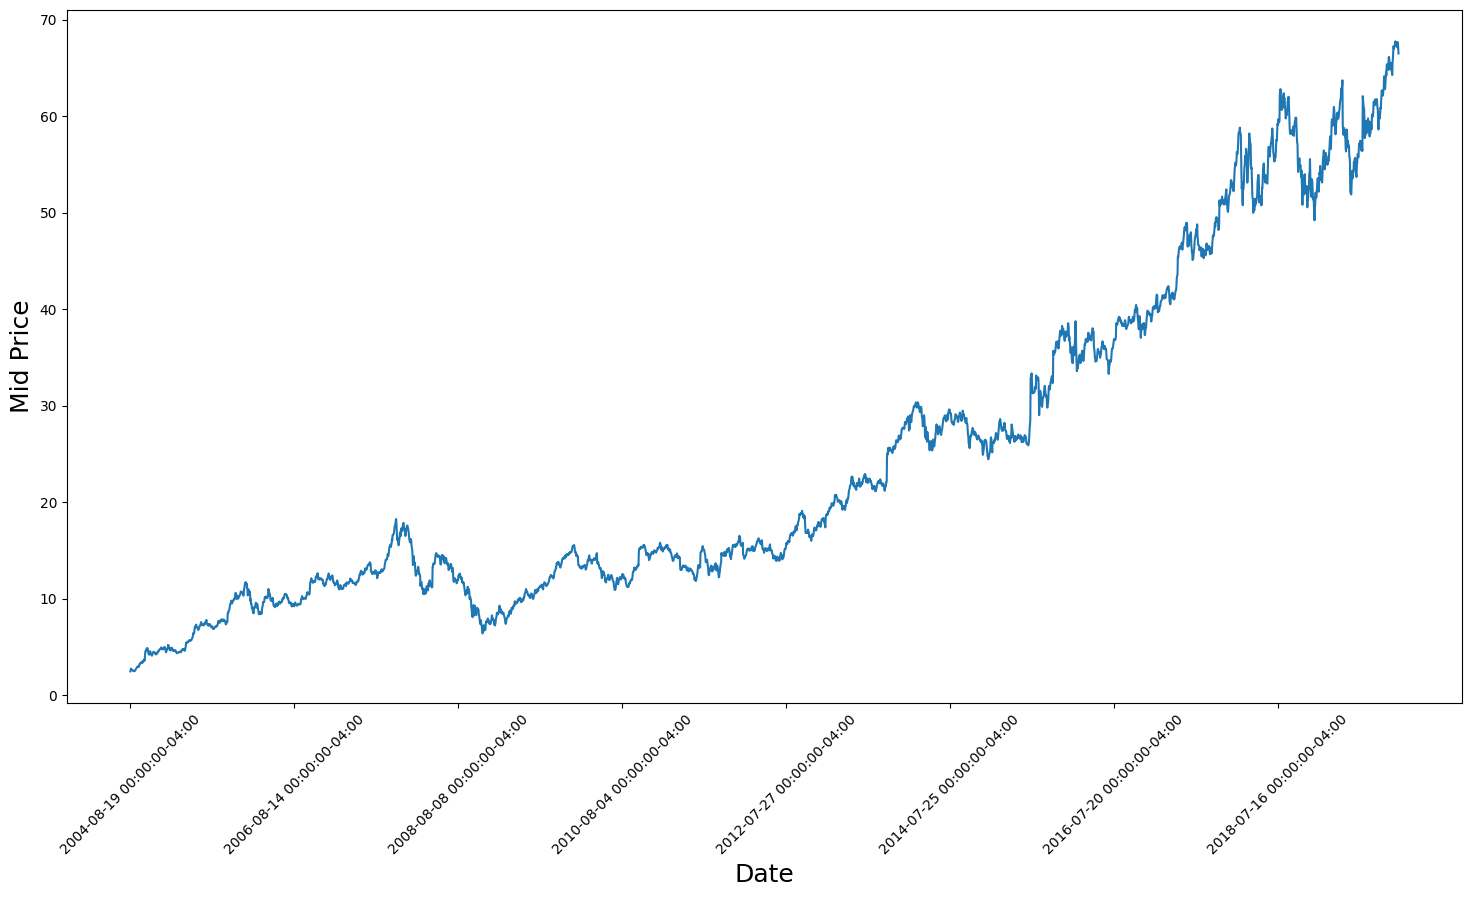

In [207]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),(data['Low']+data['High'])/2.0)
plt.xticks(range(0,data.shape[0],500),data.index[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Model

In [208]:
#add factors to input data 
window = 10 #try optimising this 
data['Momentum'] = data['Close'].pct_change(periods=window)

# Calculate rolling volatility
data['Volatility'] = data['Close'].rolling(window=window).std()


In [209]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Momentum,Volatility
Date,,,,,,,,,
2004-08-19 00:00:00-04:00,2.484562,2.585436,2.384187,2.493011,897427216,0.0,0.0,NaN,NaN
2004-08-20 00:00:00-04:00,2.509657,2.710161,2.496986,2.691030,458857488,0.0,0.0,NaN,NaN
2004-08-23 00:00:00-04:00,2.751654,2.819482,2.709416,2.718112,366857939,0.0,0.0,NaN,NaN
2004-08-24 00:00:00-04:00,2.763828,2.772772,2.573262,2.605561,306396159,0.0,0.0,NaN,NaN
2004-08-25 00:00:00-04:00,2.607797,2.683328,2.580964,2.633636,184645512,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,67.259824,67.347606,66.974522,67.013428,6950000,0.0,0.0,-0.000818,0.266419
2019-12-26 00:00:00-05:00,67.143604,67.899598,67.058813,67.853355,13350000,0.0,0.0,0.011435,0.280941
2019-12-27 00:00:00-05:00,67.982550,68.059365,67.300228,67.428909,20768000,0.0,0.0,0.001200,0.278468


In [210]:
# Drop NaN values in X (first window)
data = data[window:]
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Momentum,Volatility
Date,,,,,,,,,
2004-09-02 00:00:00-04:00,2.464438,2.543447,2.458226,2.522079,303810504,0.0,0.0,0.011660,0.079253
2004-09-03 00:00:00-04:00,2.508166,2.527794,2.467668,2.484811,103538639,0.0,0.0,-0.076632,0.081401
2004-09-07 00:00:00-04:00,2.509657,2.534254,2.474873,2.523819,117506800,0.0,0.0,-0.071481,0.068262
2004-09-08 00:00:00-04:00,2.502948,2.559846,2.496986,2.541708,100186120,0.0,0.0,-0.024506,0.067096
2004-09-09 00:00:00-04:00,2.547422,2.551894,2.509408,2.541956,81620792,0.0,0.0,-0.034811,0.061874
...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,67.259824,67.347606,66.974522,67.013428,6950000,0.0,0.0,-0.000818,0.266419
2019-12-26 00:00:00-05:00,67.143604,67.899598,67.058813,67.853355,13350000,0.0,0.0,0.011435,0.280941
2019-12-27 00:00:00-05:00,67.982550,68.059365,67.300228,67.428909,20768000,0.0,0.0,0.001200,0.278468


In [211]:
#choose features 
feature_data = data[['Close', 'Momentum', 'Volatility']]

#normalise data 
scaler = MinMaxScaler()
feature_data_scaled = scaler.fit_transform(feature_data)

In [212]:
#split data into training and test sets
train_size = 0.8  # 80% training, 20% testing
train_data, test_data = train_test_split(feature_data_scaled, train_size=train_size, shuffle=False)

#define the sequence length 
sequence_length = 50 #shorter for index 
X, y = [], []

#convert to numpy 
train_data_np = train_data

#create sequences for X and target for y
for i in range(sequence_length, len(train_data_np)):
    # X includes all features from train_data_np over the sequence length
    X.append(train_data_np[i - sequence_length:i])  # Shape (sequence_length, num_features)
    
    # y uses only the 'Close' price as the target value
    y.append(train_data_np[i, 0])  # Only the 'Close' column

#convert X and y to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, sequence_length, features)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

print("X shape:", X.shape)  # Expected shape: (samples, sequence_length, num_features)
print("y shape:", y.shape)  # Expected shape: (samples,)


X shape: (3037, 50, 3)
y shape: (3037,)


In [213]:
# LSTM model
n_features =  X.shape[2]

#try and prevent overfitting 
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

#split into train and validation data 
a = int(len(X))
b = int(a*0.8)
X_train = X[:b]
X_valid = X[b:a]
y_train = y[:b]
y_valid = y[b:a]


# need to tune hyperparameters and experiemnt with numbers of layers, activation function, lr 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error') #add early stopping 

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=32, callbacks=[early_stopping], verbose=1)                  


Epoch 1/20


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0079 - val_loss: 2.8864e-04
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1890e-04 - val_loss: 4.4256e-04
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2339e-04 - val_loss: 2.3383e-04
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6552e-04 - val_loss: 2.5259e-04
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2748e-04 - val_loss: 3.4122e-04
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6257e-04 - val_loss: 2.9562e-04


In [214]:
# Prepare test sequences
X_test, y_test = [], []

test_data_np = test_data

#create sequences for X and target for y
for i in range(sequence_length, len(test_data_np)):
    # X includes all features from train_data_np over the sequence length
    X_test.append(test_data_np[i - sequence_length:i])  # Shape (sequence_length, num_features)
    
    # y uses only the 'Close' price as the target value
    y_test.append(test_data_np[i, 0])  # Only the 'Close' column
    
X_test, y_test = np.array(X_test), np.array(y_test)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Predict and inverse scale the results
predictions = model.predict(X_test)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [215]:
len(test_data), len(X_test)

(772, 722)

In [216]:
test_data

array([[0.54088593, 0.37437429, 0.10859966],
       [0.55009779, 0.40092854, 0.11438916],
       [0.554086  , 0.42678804, 0.13575609],
       ...,
       [0.99292327, 0.39684619, 0.0797935 ],
       [0.98091268, 0.38134967, 0.11081913],
       [0.98158374, 0.36711539, 0.11741061]])

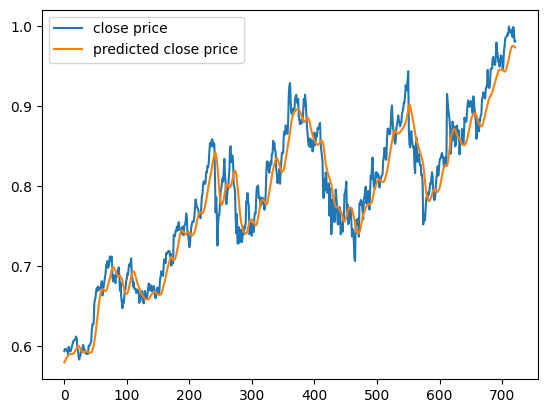

In [217]:
plt.plot(y_test, label='close price')
plt.plot(predictions, label='predicted close price')
plt.legend()

In [218]:
#model evaluation
mse = (1/len(predictions))*((np.concatenate(predictions) - y_test**2))
print(f"MSE: {mse.mean():0.10f} (+/- {mse.std():0.10f})")

MSE: 0.0002059666 (+/- 0.0000920902)


In [219]:
#scale back predictions - check this 
unscaled_predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 2)))))[:, 0]

In [220]:
unscaled_predictions[:20] 

array([40.3776657 , 40.47664622, 40.58713528, 40.69337881, 40.79380179,
       40.878997  , 40.94834846, 40.98326786, 41.02277585, 41.0529624 ,
       41.06822136, 41.06681398, 41.0626776 , 41.06640463, 41.08395594,
       41.12509353, 41.18773168, 41.27112576, 41.35981018, 41.4587556 ])

In [221]:
#use all columns 
unscaled_train_data, unscaled_test_data = train_test_split(data, train_size=train_size, shuffle=False)

unscaled_test_data = unscaled_test_data[sequence_length:] #predictions start after sequence length i.e. 60 or 60+1? might need to shift by 1

#predictions = scaler.inverse_transform(predictions)
unscaled_test_data['Predicted'] = unscaled_predictions #this is scaled need to inverse scale 

In [222]:
unscaled_test_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Momentum,Volatility,Predicted
Date,,,,,,,,,,
2017-02-17 00:00:00-05:00,41.050187,41.302067,40.982101,41.302067,32220000,0.0,0.0,0.033163,0.422063,40.377666
2017-02-21 00:00:00-05:00,41.331495,41.570410,41.316034,41.481129,25246000,0.0,0.0,0.037837,0.420112,40.476646
2017-02-22 00:00:00-05:00,41.331495,41.560433,41.330498,41.436237,19658000,0.0,0.0,0.029481,0.413191,40.587135
2017-02-23 00:00:00-05:00,41.404319,41.521033,41.043207,41.464672,29456000,0.0,0.0,0.028390,0.384803,40.693379
2017-02-24 00:00:00-05:00,41.285111,41.348455,41.109041,41.330498,27844000,0.0,0.0,0.023568,0.314815,40.793802
...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,67.259824,67.347606,66.974522,67.013428,6950000,0.0,0.0,-0.000818,0.266419,66.306167
2019-12-26 00:00:00-05:00,67.143604,67.899598,67.058813,67.853355,13350000,0.0,0.0,0.011435,0.280941,66.289278
2019-12-27 00:00:00-05:00,67.982550,68.059365,67.300228,67.428909,20768000,0.0,0.0,0.001200,0.278468,66.278113


In [223]:
#try backtesting on train data 



In [229]:
#BUY_THRESHOLD = 0.05
#SELL_THRESHOLD = -0.05

class LSTMThresholdStrategy(Strategy):
    BUY_THRESHOLD = 0.05  
    SELL_THRESHOLD = -0.05  

    def init(self):
        #store predicted price change as an indicator
        self.predicted_change = self.I(self.calculate_predicted_change, name='percentage change')

    def calculate_predicted_change(self):
        #calculate the percentage change between consecutive predicted prices
        
        p_change =  ( self.data['Predicted'] - self.data['Close'] ) / self.data['Close'] 
        
        return p_change

    def next(self):
        #check if the predicted change exceeds the buy threshold
        if self.predicted_change[-1] > BUY_THRESHOLD:
            self.position.close() #what does this do 
            self.buy()
        
        #check if the predicted change is below the sell threshold
        elif self.predicted_change[-1] < SELL_THRESHOLD:
            self.position.close()
            self.sell()

bt = Backtest(unscaled_test_data, LSTMThresholdStrategy, cash=10000, commission=0.001) #only using next year after model trained! 

#run backtest
output = bt.run()
print(output)

#plot results
bt.plot()


Start                     2017-02-17 00:00...
End                       2019-12-31 00:00...
Duration                   1047 days 00:00:00
Exposure Time [%]                   93.213296
Equity Final [$]                 12429.080884
Equity Peak [$]                  14453.716003
Return [%]                          24.290809
Buy & Hold Return [%]               61.462199
Return (Ann.) [%]                    7.885255
Volatility (Ann.) [%]               26.825261
Sharpe Ratio                         0.293949
Sortino Ratio                        0.523818
Calmar Ratio                         0.273886
Max. Drawdown [%]                  -28.790269
Avg. Drawdown [%]                    -6.61333
Max. Drawdown Duration      308 days 00:00:00
Avg. Drawdown Duration       53 days 00:00:00
# Trades                                   51
Win Rate [%]                        47.058824
Best Trade [%]                      18.006348
Worst Trade [%]                    -10.140792
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p12603', ...)

In [225]:
np.array(range(1, 11, 1))*0.01

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [230]:
#optimise thresholds
stats = bt.optimize(BUY_THRESHOLD=list(np.array(range(1, 11, 1))*0.01), SELL_THRESHOLD=list(np.array(range(1, 11, 1))*0.01), maximize='Equity Final [$]')
stats


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


Start                     2017-02-17 00:00...
End                       2019-12-31 00:00...
Duration                   1047 days 00:00:00
Exposure Time [%]                   93.213296
Equity Final [$]                 12429.080884
Equity Peak [$]                  14453.716003
Return [%]                          24.290809
Buy & Hold Return [%]               61.462199
Return (Ann.) [%]                    7.885255
Volatility (Ann.) [%]               26.825261
Sharpe Ratio                         0.293949
Sortino Ratio                        0.523818
Calmar Ratio                         0.273886
Max. Drawdown [%]                  -28.790269
Avg. Drawdown [%]                    -6.61333
Max. Drawdown Duration      308 days 00:00:00
Avg. Drawdown Duration       53 days 00:00:00
# Trades                                   51
Win Rate [%]                        47.058824
Best Trade [%]                      18.006348
Worst Trade [%]                    -10.140792
Avg. Trade [%]                    

In [231]:
stats._strategy

<Strategy LSTMThresholdStrategy(BUY_THRESHOLD=0.01,SELL_THRESHOLD=0.01)>

not sure if this is sound, it's minimised threshold just luck that makes profit? 

### Model for multiday forecasting 

In [ ]:
#try strategy using a few days in advance 

## Final Test

### More code 

In [48]:
class LSTMStrategy(Strategy):
    def init(self):
        # Predict future price movements with the LSTM model
        self.predictions = predictions 
        self.index = 0
        self.threshold = 0.02  #2% threshold -> optimise 

    def next(self): #not working atm 

        if self.index < len(self.predictions):
            current_price = self.data.Close[-1] #is this correct
            predicted_price = self.predictions[self.index]
            
            # Calculate expected return as a percentage
            expected_return = (predicted_price - current_price) / current_price
            
            # Check for buy/sell signals based on threshold
            if expected_return > self.threshold:
                if not self.position.is_long:
                    self.buy()  # Open or hold a long position
            elif expected_return < -self.threshold:
                if not self.position.is_short:
                    self.sell()  # Open or hold a short position
            else:
                # Close position if the expected return is within the threshold
                if self.position:
                    self.position.close()
            
            self.index += 1
        

# Run the backtest on example data
bt = Backtest(test_data, LSTMStrategy, cash=10000, commission=.002)
stats = bt.run()
bt.plot()



/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p1985', ...)

In [40]:
stats

Start                     2000-01-03 00:00...
End                       2019-12-31 00:00...
Duration                   7302 days 00:00:00
Exposure Time [%]                   99.960246
Equity Final [$]                897427.712345
Equity Peak [$]                 902349.307886
Return [%]                        8874.277123
Buy & Hold Return [%]             8341.952794
Return (Ann.) [%]                   25.263534
Volatility (Ann.) [%]               52.488908
Sharpe Ratio                         0.481312
Sortino Ratio                        0.891071
Calmar Ratio                         0.308853
Max. Drawdown [%]                  -81.797794
Avg. Drawdown [%]                   -5.328314
Max. Drawdown Duration     1771 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                    8874.826324
Worst Trade [%]                   8874.826324
Avg. Trade [%]                    

In [58]:
class FactorStrategy(Strategy):
    
    def init(self):
        # Initialize an indicator to store predictions
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):

        # Prepare the latest feature data for prediction
        features = self.data.df.iloc[-1:][['Momentum', 'Volatility']]
        predicted_return = model.predict(features)[0]

        # Update forecast indicator for plotting
        self.forecasts[-1] = predicted_return

        # Implement buy/sell logic based on predicted return
        if predicted_return > 0:
            self.buy(size=0.5) #calculate best size 
            
        elif predicted_return < 0:
            self.sell(size=0.5)
            

# Run the backtest on training data 
bt = Backtest(test_data, FactorStrategy, cash=10000, commission=0.002)
stats = bt.run()

print(stats)
bt.plot()

TypeError: `data` must be a pandas.DataFrame with columns

In [102]:
!pip list

Package                           Version
--------------------------------- ------------
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.2
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
applaunchservices                 0.3.0
appnope                           0.1.2
appscript                         1.1.2
archspec                          0.2.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                  

In [ ]:
#backtesting - need to check 

# Example thresholds 
buy_threshold = 0.005  
sell_threshold = -0.005 
predicted_prices = predictions
signals = []
for i in range(len(predicted_prices) - 1):
    predicted_change = (predicted_prices[i+1] - predicted_prices[i]) / predicted_prices[i]
    
    if predicted_change > buy_threshold:
        signals.append("Buy")
    elif predicted_change < sell_threshold:
        signals.append("Sell")
    else:
        signals.append("Hold")


# Set parameters
initial_capital = 100000
capital = initial_capital
positions = 0  # Number of shares held
transaction_fee = 0.001  # 0.1% per transaction

actual_prices = test_data[:,0]

portfolio_values = []

# Simulate strategy
for i, signal in enumerate(signals):
    current_price = actual_prices[i]

    if signal == "Buy" and positions == 0:
        positions = (capital * (1 - transaction_fee)) / current_price
        capital = 0
    elif signal == "Sell" and positions > 0:
        capital = positions * current_price * (1 - transaction_fee)
        positions = 0

    # Update portfolio value
    portfolio_value = capital if positions == 0 else positions * current_price
    portfolio_values.append(portfolio_value)

# Calculate performance
roi = (portfolio_values[-1] - initial_capital) / initial_capital
print("Final Portfolio Value:", portfolio_values[-1])
print("Return on Investment (ROI):", roi * 100, "%")
